In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('../Input/Books_rating.csv')#.iloc[:5000]
df['time'] = pd.to_datetime(df['time'], unit='s')
print('shape: ',df.shape)
df.head()

shape:  (3000000, 9)


,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,1999-10-23,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,5.0,2004-09-21,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,5.0,2004-03-09,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,2004-07-25,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,2005-02-10,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


# Summary Statistics

In [12]:
df[['Title','User_id']].describe(include='object')

,Title,User_id
count,2999792,2438213
unique,212403,1008972
top,The Hobbit,A14OJS0VWMOSWO
freq,22023,5795


In [29]:
df.describe()

,Price,score,time
count,481171.000000,3.000000e+06,3000000
mean,21.762656,4.215289e+00,2005-11-18 09:39:32.630393216
min,1.000000,1.000000e+00,1969-12-31 23:59:59
25%,10.780000,4.000000e+00,2001-09-08 00:00:00
50%,14.930000,5.000000e+00,2005-10-03 00:00:00
75%,23.950000,5.000000e+00,2010-03-21 00:00:00
max,995.000000,5.000000e+00,2013-03-04 00:00:00
std,26.206541,1.203054e+00,NaN


# Missing Data Analysis

In [3]:
missing_data = df.isnull().sum()
missing_data_percentage = (missing_data / len(df)) * 100

# Create a dataframe to better visualize missing data
missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_data_percentage
}).sort_values(by='Missing Values', ascending=False)

# Display missing data summary
print("Missing Data Analysis:")
print(missing_data_df)

Missing Data Analysis:
             Missing Values  Percentage
Price               2518829   83.960967
profileName          561905   18.730167
User_id              561787   18.726233
summary                 407    0.013567
Title                   208    0.006933
text                      8    0.000267
Id                        0    0.000000
time                      0    0.000000
score                     0    0.000000


In [30]:

print("\nMissing Data Analysis:")
print(df.isnull().sum())

# # Visualizing Missing Data
# plt.figure(figsize=(10, 6))
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Data Heatmap')
# plt.show()


Missing Data Analysis:
Id                   0
Title              208
Price          2518829
User_id         561787
profileName     561905
score                0
time                 0
summary            407
text                 8
dtype: int64


# Individual Variables

## Titles

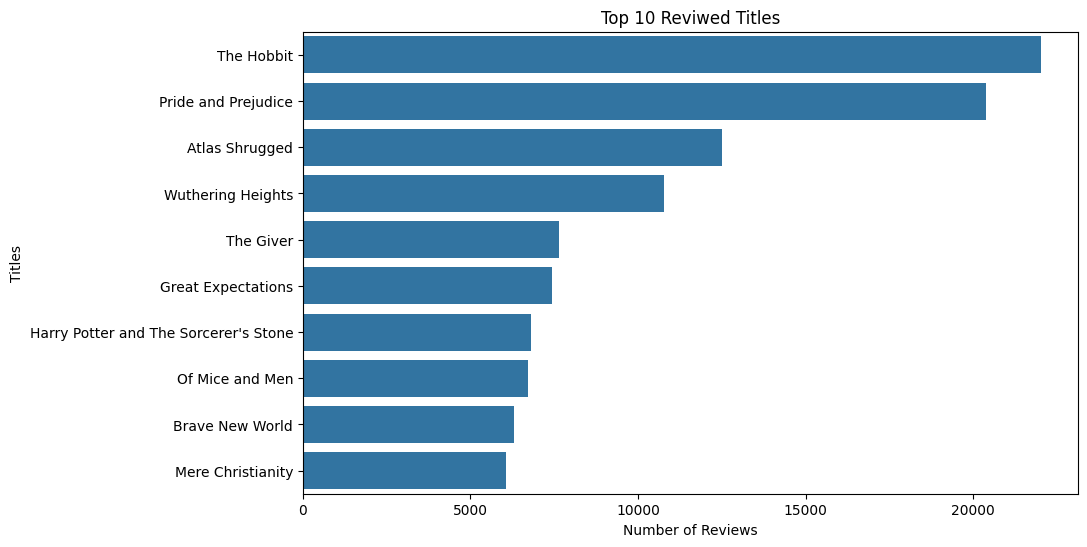

In [21]:
# Counting the number of books per author
title_counts = df['Title'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=title_counts.head(10).values, y=title_counts.head(10).index)
plt.title('Top 10 Reviwed Titles')
plt.xlabel('Number of Reviews')
plt.ylabel('Titles')
plt.show()

## Reviwers

In [32]:
# # Counting the number of books per author
# title_counts = df['User_id'].value_counts()


# plt.figure(figsize=(10, 6))
# sns.barplot(x=title_counts.head(10).values, y=title_counts.head(10).index)
# plt.title('Top 10 Reviwed Titles')
# plt.xlabel('Number of Reviews')
# plt.ylabel('Titles')
# plt.show()

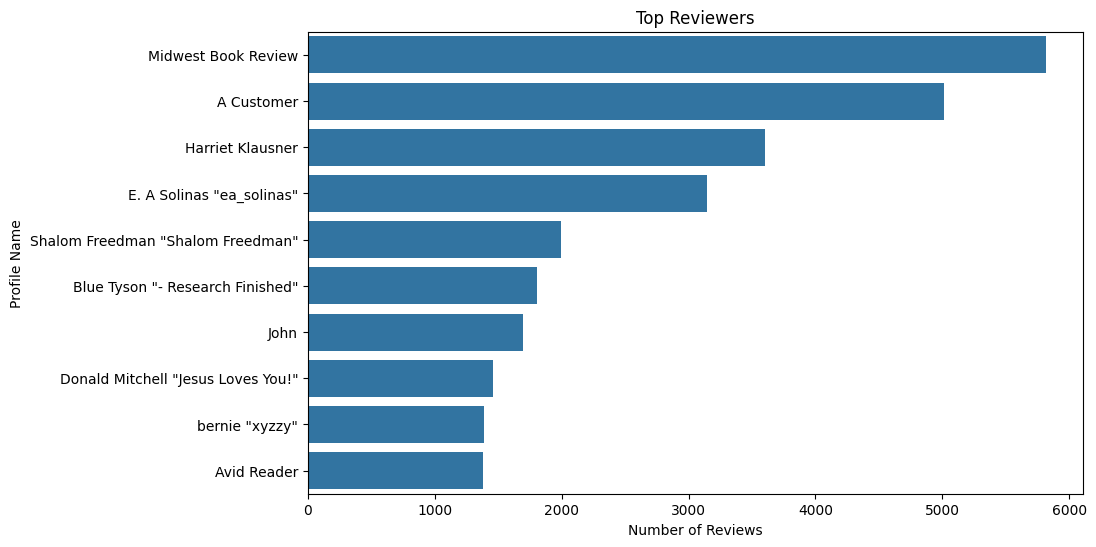

In [42]:
# Visualizing Top Reviewers
plt.figure(figsize=(10, 6))
sns.barplot(x=top_reviewers.values, y=top_reviewers.index)
plt.title('Top Reviewers')
plt.xlabel('Number of Reviews')
plt.ylabel('Profile Name')
plt.show()

## Distribution of Ratings

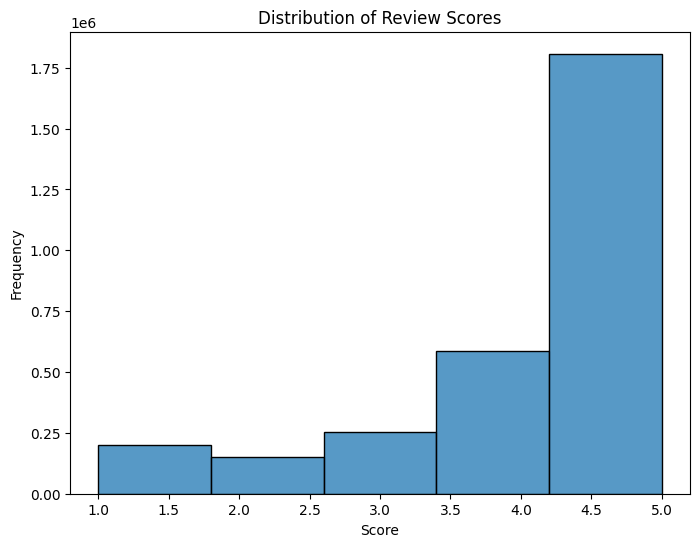

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(df['score'], bins=5)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

## Time

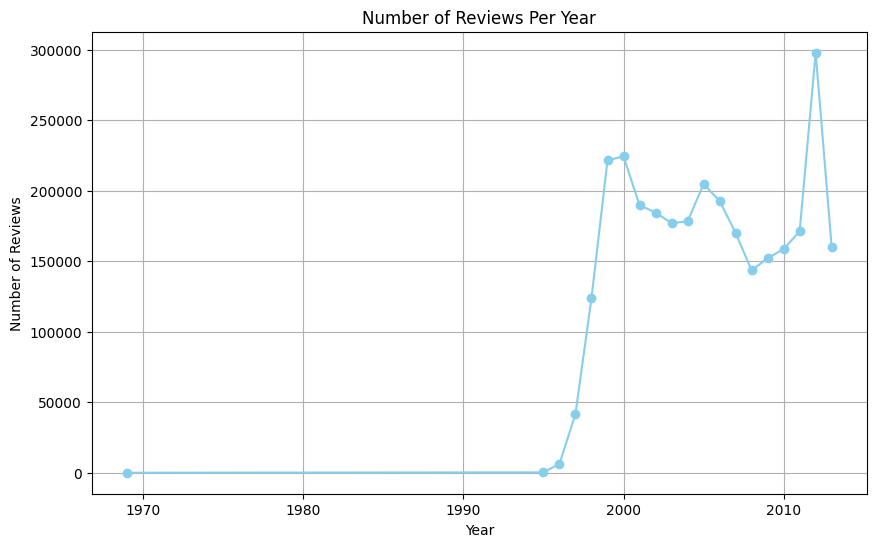

In [39]:
df['year'] = df['time'].dt.year

# Group by year and count the number of reviews
reviews_per_year = df.groupby('year').size()

# Plotting the number of reviews per year as a line plot
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', linestyle='-', color='skyblue')
plt.title('Number of Reviews Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

# Text Analysis

In [57]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/mateus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mateus/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/mateus/nltk_data...


True

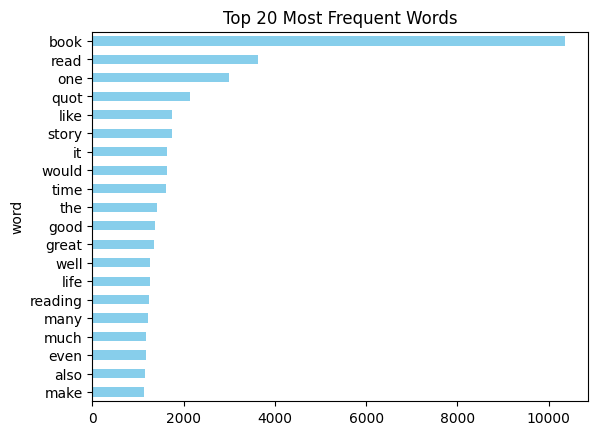

In [58]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text (lemmatization and removing stopwords)
def preprocess_text(text):
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply preprocessing to the 'text' column
df['processed_text'] = df['text'].fillna('').apply(preprocess_text)


# Step 1: Word Frequency Analysis
def plot_word_frequency(text_data, top_n=20):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(text_data)
    
    # Sum up the counts of each word
    sum_words = word_counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Plotting the results
    words_df = pd.DataFrame(words_freq, columns=['word', 'count'])
    words_df.plot(kind='barh', x='word', y='count', legend=False, color='skyblue')
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.gca().invert_yaxis()
    plt.show()

# Apply the function to the 'text' column
plot_word_frequency(df['processed_text'].fillna(''))


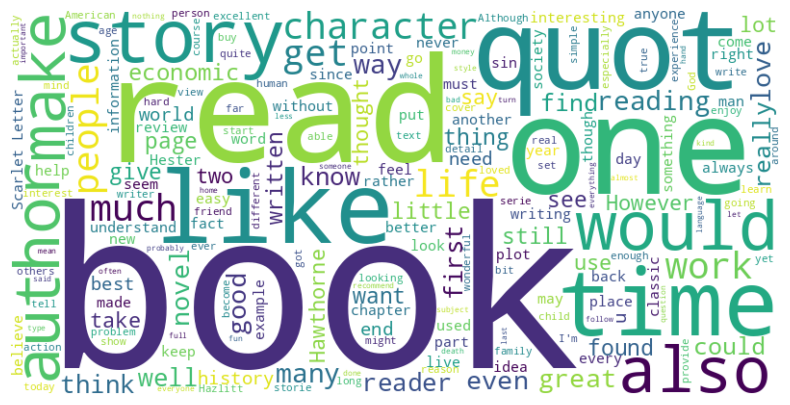

In [54]:

# Step 2: Generate a Word Cloud
def generate_word_cloud(text_data):
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                          background_color='white',
                          width=800,
                          height=400).generate(" ".join(text_data))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud for the 'text' column
generate_word_cloud(df['text'].fillna(''))


Sentiment Analysis Summary:
 count    5000.000000
mean        0.205949
std         0.196299
min        -1.000000
25%         0.089996
50%         0.187932
75%         0.306850
max         1.000000
Name: sentiment, dtype: float64


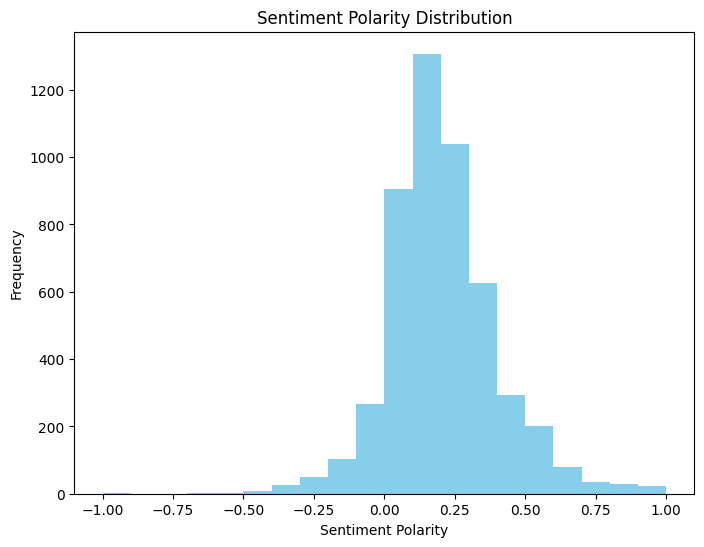

,Title,score,sentiment
4999,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.296104
4998,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.154552
1,Dr. Seuss: American Icon,5.0,0.214121
2,Dr. Seuss: American Icon,5.0,0.266271
4996,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.499444
4980,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.120000
4979,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.222000
4978,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.175000
4977,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.252381
4976,Lifetimes: The Beautiful Way to Explain Death ...,5.0,0.000000


In [55]:

# Step 3: Sentiment Analysis
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the 'text' column
df['sentiment'] = df['text'].fillna('').apply(analyze_sentiment)

# Summary statistics of sentiment
sentiment_summary = df['sentiment'].describe()
print("Sentiment Analysis Summary:\n", sentiment_summary)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment'], bins=20, color='skyblue')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Analyze sentiment for top n reviews by score
top_reviews = df.sort_values(by='score', ascending=False).head(10)
top_reviews[['Title', 'score', 'sentiment']]


In [69]:
df['scored_diff'] = df['score'] - df['sentiment']

In [72]:
df.sort_values(by='scored_diff', ascending=False)

,Id,Title,Price,User_id,profileName,score,time,summary,text,sentiment,processed_text,scored_diff
3321,B000NSKB12,The Castle in the Attic,NaN,NaN,NaN,5.0,2000-03-06,Fantasy,"Well, to begin with, it's fantasy. With knight...",-0.466667,"well, begin with, fantasy. knight(s), wizard, ...",5.466667
1471,B0007H4QBK,Economics in one lesson,NaN,A1DKF1QWFJH1OM,Evan Rogers,5.0,2011-02-01,Changed my life,I know it sounds stupid. I know it sounds extr...,-0.375000,know sound stupid. know sound extreme. know so...,5.375000
1975,B000N6DDJQ,The Scarlet Letter A Romance,NaN,NaN,NaN,5.0,1999-05-05,"One of the best novels ever, hands down. Wake ...",Perhaps this is not exactly a review of Hawtho...,-0.334259,perhaps exactly review hawthorne's scarlet let...,5.334259
325,0802422772,No place to cry: The hurt and healing of sexua...,NaN,A3O416XZO4WBR4,Jessica M. Cantner,5.0,2010-12-27,Wonderful book,This book is unbelievably sad. I couldn't put ...,-0.327778,book unbelievably sad. put down. opened eye ch...,5.327778
1596,081673447X,Spooky Kids: Strange But True Tales,NaN,NaN,NaN,5.0,1998-04-24,It's accelerating!,spooky kids is spookier than R.L Stine's GOOSE...,-0.325000,spooky kid spookier r.l stine's goosebumps. sa...,5.325000
...,...,...,...,...,...,...,...,...,...,...,...,...
2313,B000N6DDJQ,The Scarlet Letter A Romance,NaN,A1BEYRE9RKI2OA,Jesse,1.0,2000-10-11,paralyzing fear,The pain brought on by this archaicly verbose ...,0.358989,pain brought archaicly verbose peice literary ...,0.641011
997,0375422811,The Rabbi's Cat,16.93,A2W9NRDLQS4M09,Syrena,1.0,2006-02-07,Self-Serving Message,"This is the tale of a kindly Rabbi, his sweet ...",0.371528,"tale kindly rabbi, sweet daughter cat love her...",0.628472
2543,B00085GEUC,The principles of science;: A treatise on logi...,NaN,AD71LKT5V5RH1,K. Barnett,1.0,2008-05-03,Illegible,It was an illegible **photocopy**. It appeared...,0.375000,illegible **photocopy**. appeared someone took...,0.625000
1019,B0007FXCVM,Triumph in the Philippines (United States Army...,NaN,A2A181RJGPEXG9,"R. Fournier ""Book Junkie""",1.0,2012-10-14,Impossible to read,This kindly adaptation is a mishmash of gibber...,0.425000,kindly adaptation mishmash gibberish. amazon r...,0.575000


In [75]:
print(df.loc[1471])
print(df.loc[1471,'text'])

Id                                                       B0007H4QBK
Title                                       Economics in one lesson
Price                                                           NaN
User_id                                              A1DKF1QWFJH1OM
profileName                                             Evan Rogers
score                                                           5.0
time                                            2011-02-01 00:00:00
summary                                             Changed my life
text              I know it sounds stupid. I know it sounds extr...
sentiment                                                    -0.375
processed_text    know sound stupid. know sound extreme. know so...
scored_diff                                                   5.375
Name: 1471, dtype: object
I know it sounds stupid. I know it sounds extreme. I know it sounds ridiculous.But this book REALLY DID change my life.I used to be a bleeding-heart liberal: 